In [19]:
# imports here
import json
from tqdm import tqdm
import re
import tiktoken
from openai import OpenAI
from dotenv import load_dotenv
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

load_dotenv()


True

In [9]:
def load_dataset(path:str =  "/millcreek/home/sunil/r1_vlm_bumbershoot2/r1_vlm/src/r1_vlm/environments/simple_aokvqa_env/aokvqa_examples.jsonl"):
    dataset_list = []
    with open(path, "r") as f:
        for line in tqdm(f, desc="Loading dataset as list"):
            dataset_list.append(json.loads(line))
    
    # sort the data by the question_id key
    dataset_dict = {}
    
    for example in tqdm(dataset_list, desc="Sorting dataset by question_id"):
        question_id = example["question_id"]
        if question_id not in dataset_dict:
            dataset_dict[question_id] = []
        dataset_dict[question_id].append(example)
    
    return dataset_dict


dataset = load_dataset()

Loading dataset as list: 21108it [00:00, 70070.99it/s]
Sorting dataset by question_id: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21108/21108 [00:00<00:00, 1854606.88it/s]


In [10]:
def extract_thinking(text: str) -> str:
    """Extract content between <think> and </think> tags. Returns None if no match is found."""
    pattern = r'<think>(.*?)</think>'
    match = re.search(pattern, text, re.DOTALL)  # re.DOTALL allows matching across newlines
    return match.group(1).strip() if match else None



In [11]:
# source: https://platform.openai.com/docs/guides/embeddings#how-can-i-tell-how-many-tokens-a-string-has-before-i-embed-it

# using this fn, I estimated the cost of embeddign the entire dataset at $0.04...total...LOL (between 2 and 3 million tokens)
def num_tokens_from_string(string: str, encoding_name: str= "cl100k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [12]:
# source: https://platform.openai.com/docs/guides/embeddings
client = OpenAI()

def get_embedding(text:str, model="text-embedding-3-small"):
    text = text.replace("\n", " ")
    return client.embeddings.create(input = [text], model=model).data[0].embedding



In [13]:
def get_embeddings(examples:list[dict]):
    '''
    Given a list of examples from the same question id, return the completions, rationales, and model correctness, and embeddings
    '''
    # rationales are consistent across all examples
    rationales = examples[0]["rationales"]
    
    completions = [example["completion"] for example in examples]
    
    # convert to bools - either correct or incorrect
    model_correctness = [example["correctness_reward"] > 0.0 for example in examples]
    thinking_content = [extract_thinking(c) for c in completions]
    
    # map each thinking content to its corresponding model correctness
    data = [(thinking_content, model_correctness) for thinking_content, model_correctness in zip(thinking_content, model_correctness)]
    
    # remove examples where we couldn't extract thinking content
    data = [d for d in data if d[0] is not None and d[0] != ""]
    
    thinking_content = [d[0] for d in data]
    model_correctness = [d[1] for d in data]
    
    rationale_embeddings = [get_embedding(text=r) for r in rationales]
    completion_embeddings = [get_embedding(text=c) for c in thinking_content]
    
    ret_data = {
        "rationale_embeddings": rationale_embeddings,
        "completion_embeddings": completion_embeddings,
        "model_correctness": model_correctness,
        "thinking_content": thinking_content
    }
    
    return ret_data
    

    

Processing dataset:   0%|                                                                                                                                                                    | 0/1759 [00:00<?, ?it/s]

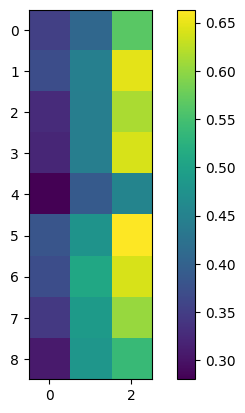

Processing dataset:   0%|                                                                                                                                                                    | 0/1759 [00:06<?, ?it/s]


In [20]:
# Example keys:
# 'question_id', 
# 'question', 
# 'choices', 
# 'difficult_direct_answer', 
# 'correct_choice_idx', 
# 'direct_answers', 
# 'rationales', 
# 'completion', 
# 'correctness_reward'

for question_id, examples in tqdm(dataset.items(), desc="Processing dataset"):
    
    preprocessed_data = get_embeddings(examples)
    
    rationale_embeddings = preprocessed_data["rationale_embeddings"]
    completion_embeddings = preprocessed_data["completion_embeddings"]
    model_correctness = preprocessed_data["model_correctness"]
    thinking_content = preprocessed_data["thinking_content"]
    
    similarities = cosine_similarity(completion_embeddings, rationale_embeddings)
    
    plt.imshow(similarities)
    plt.colorbar()
    plt.show()
    
    
    
    
    
    
    
    break
    
    

    
    
    

    

    
    
    
    
    
    

In [15]:
preprocessed_data

{'rationale_embeddings': [[-0.0008876406354829669,
   -0.02509523741900921,
   0.00841793604195118,
   -0.03394751623272896,
   -0.05537498742341995,
   0.02226857654750347,
   -0.0016149888979271054,
   0.040290266275405884,
   0.019703898578882217,
   0.010279395617544651,
   -0.033175352960824966,
   -0.02218584530055523,
   -0.0371740460395813,
   -0.004984576255083084,
   0.023399241268634796,
   0.030555520206689835,
   0.0037849685177206993,
   -0.030086709186434746,
   -0.02226857654750347,
   0.021510204300284386,
   0.03565730154514313,
   -0.018380193039774895,
   0.03430601954460144,
   -0.011547946371138096,
   0.014533176086843014,
   -0.03902171552181244,
   -0.04575055092573166,
   -0.03601580485701561,
   0.013181894086301327,
   -0.036539770662784576,
   0.04285494610667229,
   -0.04608147591352463,
   0.01028629019856453,
   -0.03218257427215576,
   -0.02775643579661846,
   -0.0022165162954479456,
   0.022571925073862076,
   0.03356143459677696,
   -0.003653977066278